In [1]:
import numpy as np
import scipy.linalg as la
import math
from scipy.stats import uniform_direction
from math import atan, log, pi
from datetime import datetime as dt
from sklearn.metrics import accuracy_score

class Optimizer:
    def __init__(self, func, grad_func, hessian_func, w0, learning_rate, iter, args, name, label):
        self.func = func
        self.grad_func = grad_func
        self.w = w0
        self.iter = iter
        self.learning_rate = learning_rate
        self.args = args
        self.name = name
        self.label = label
        self.errors = []
        self.accuracy = []
        self.time = []
        self.v = self.grad_func(self.w, self.args)
        self.hessian_func = hessian_func
        self.args['w_prev'] = self.w

    def gd(self, w, k):
        lr = self.learning_rate(w, self.args)
        return w - lr * self.grad_func(w, self.args) 
    
    def predict(self, X):
        return np.sign(X @ self.w)
    
    def cubic_newton(self, x, k):
        M = 3/8*np.sqrt(3)
        D1 = (1/(1+x**2)) ** 2 + 2*M*x*atan(x)
        D2 = (1/(1+x**2)) ** 2 - 2*M*x*atan(x)
        f = lambda y: atan(x)*(y-x) + 0.5/(1+x**2)*(y-x)**2 + M/6*abs(y-x)**3
        
        y1 = x + (-1/(1+x**2) + np.sqrt(D1))/M
        y2 = x + (-1/(1+x**2) - np.sqrt(D1))/M
        y3 = x + (-1/(1+x**2) + np.sqrt(D2))/M
        y4 = x + (-1/(1+x**2) - np.sqrt(D2))/M

        if f(y1) > f(y2):
            y1 = y2
        if f(y1) > f(y3):
            y1 = y3
        if f(y1) > f(y4):
            return y4

        return y1

    def newton(self, w, k):
        lr = self.learning_rate(w, self.args)
        if self.args['test']:
            return w - lr*np.linalg.inv(self.hessian_func(w, self.args)) @ self.grad_func(w, self.args)
        return w - lr*self.grad_func(w, self.args) / self.hessian_func(w, self.args)
    
    def approx_newton(self, w, k, dim, num_samples):
        lr = self.learning_rate(w, self.args)
        if self.args['test']:
            samples = uniform_direction.rvs(dim=dim, size=num_samples, random_state=np.random.default_rng())
            hessian = self.hessian_func(w, self.args)
            approx_hessian = np.zeros_like(hessian)
            for u in samples:
                approx_hessian += hessian.shape[0] * hessian @ np.outer(u, u)
            approx_hessian /= num_samples
            return w - lr * np.linalg.inv(approx_hessian) @ self.grad_func(w, self.args)
        
        u = uniform_direction.rvs(dim=dim, size=num_samples, random_state=np.random.default_rng())
        return w - lr*self.grad_func(w, self.args) / (dim * self.hessian_func(w, self.args) * u**2)
    
    def approx_newton_mushrooms(self, w, k, num_samples):
        lr = self.learning_rate(w, self.args)
        if self.args['test']:
            return w - lr*np.linalg.inv(self.hessian_func(w, self.args, num_samples)) @ self.grad_func(w, self.args)
        return w - lr*self.grad_func(w, self.args) / self.hessian_func(w, self.args, num_samples)
    
    def broyden(self, w, H, k):
        grad_prev = self.grad_func(w, self.args)
        d = - H @ grad_prev
        lr = self.learning_rate(w, self.args)
        w, w_prev = w + lr * d, w
        grad = self.grad_func(w, self.args)
        s = w - w_prev
        y = grad - grad_prev
        q = s - H @ y
        mu = 1 / (q @ y)
        H = H + mu * np.array([q]).T @ np.array([q])
        
        return w, H
    
    def dfp(self, w, H, k):
        grad_prev =  self.grad_func(w, self.args)
        d = - H @ grad_prev
        lr = self.learning_rate(w, self.args)
        w, w_prev = w + lr * d, w
        grad = self.grad_func(w, self.args)
        s = np.array([w - w_prev]).T
        y = np.array([grad - grad_prev]).T
        
        H = H - (H @ y @ y.T @ H) / (y.T @ H @ y) + s @ s.T / (y.T @ s)

        return w, H, w_prev
    
    def bfgs(self, w, H, k):
        grad_prev = self.grad_func(w, self.args)
        
        d = - H @ grad_prev
        lr = self.learning_rate(w, self.args)
        w, w_prev = w + lr * d, w
        grad = self.grad_func(w, self.args)
        
        s = np.array([w - w_prev]).T
        y = np.array([grad - grad_prev]).T
        
        rho = 1 / (y.T @ s)
        V = np.eye(len(w)) - rho * y @ s.T
        H = V.T @ H @ V + rho * s @ s.T
        
        return w, H, w_prev
    

    def lbfgs(self, w, H, H0, ss, ys, k):
        grad_prev = self.grad_func(w, self.args)

        d = - H @ grad_prev
        lr = self.learning_rate(w, self.args)
        w, w_prev = w + lr * d, w
        grad = self.grad_func(w, self.args)

        s = w - w_prev
        y = grad - grad_prev
        m = self.args['m']
        
        for i in range(m - 1):
            ss[ : , i] = ss[ : , i + 1]
            ys[ : , i] = ys[ : , i + 1]
        ss[ : , m - 1] = s
        ys[ : , m - 1] = y

        H = H0
        for i in range(max(0, m - k - 1), m):
            s = np.array([ss[ : , i ]]).T
            y = np.array([ys[ : , i ]]).T
            rho = 1 / (y.T @ s)
            V = np.eye(len(w)) - rho * y @ s.T
            H = V.T @ H @ V + rho * s @ s.T
        return w, H, ss, ys

    def fit(self, dim=1, num_samples=100):
        to_seconds = lambda s: s.microseconds * 1e-6 + s.seconds
        time_start = dt.now()
        
        if self.name in ['broyden', 'dfp', 'bfgs', 'lbfgs']:
            H = self.hessian_func(self.w, self.args)
            H0 = np.copy(H)
            ss = np.zeros((len(self.w), 3))
            ys = np.zeros((len(self.w), 3))

        for k in range(self.iter):
            w_prew = self.w
            if self.name == 'gd':
                self.w = self.gd(self.w, k)
            elif self.name == 'newton':
                self.w = self.newton(self.w, k)
            elif self.name == 'approx_newton':
                self.w = self.approx_newton(self.w, k, dim, num_samples)
            elif self.name == 'approx_newton_mushrooms':
                self.w = self.approx_newton_mushrooms(self.w, k, num_samples)
            elif self.name == 'cubicnewton':
                self.w = self.cubic_newton(self.w, k)
            elif self.name == 'dfp':
                self.w, H, w_prew = self.dfp(self.w, H, k)
            elif self.name  == 'bfgs':
                self.w, H, w_prew = self.bfgs(self.w, H, k)
            elif self.name == 'lbfgs':
                self.w, H, ss, ys = self.lbfgs(self.w, H, H0, ss, ys, k)
            elif self.name == 'broyden':
                self.w, H = self.broyden(self.w, H, k)

            self.args['w_prev'] = w_prew
            if self.args['test']:
                error = np.linalg.norm(self.grad_func(self.w, self.args), 2)
            else:
                error = abs(self.grad_func(self.w, self.args))

            self.time.append(to_seconds(dt.now() - time_start))
            self.errors.append(error)
            
            if self.args['test']:
                self.accuracy.append(accuracy_score(self.predict(self.args['X_test']), self.args['y_test']))
            
            if error < 1e-8:
                break

### 1D case

$\min\limits_{x \in \mathbb{R}}f(x) = x\arctan{x} - \frac12\log{\left(1+x^2\right)}$

$\nabla f(x) = \arctan{x}$

$\nabla^2f(x) = \frac{1}{1 + x^2} \succ 0$

$|2x\arctan{x}|<1$

$\gamma = \frac1L, \quad L = \frac\pi2$

In [2]:
import math
from math import atan, log, pi
import numpy as np
import matplotlib.pyplot as plt

In [3]:
args = {}
args['test'] = False
def function(x, args):
    return x*atan(x) - 0.5*log(1+x**2)
def grad_function(x, args):
    return atan(x)
def hessian_function(x, args):
    return 1/(1 + x**2)
def lr(x, args):
    return 2/pi

In [4]:
gd = Optimizer(func=function, grad_func=grad_function, hessian_func=hessian_function, w0=1.3, learning_rate=lr, iter=11, args=args, name='gd', label='GD')
gd.fit()

newton = Optimizer(func=function, grad_func=grad_function, hessian_func=hessian_function, w0=1.3, learning_rate=lambda x, args: 1, iter=11, args=args, name='newton', label='Newton')
newton.fit()

approx_1 = Optimizer(func=function, grad_func=grad_function, hessian_func=hessian_function, w0=1.3, learning_rate=lambda x, args: 1, iter=11, args=args, name='approx_newton', label='Approx Newton, 1 sample')
approx_1.fit(num_samples=1)

/tmp/ipykernel_2573507/2747588694.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return atan(x)


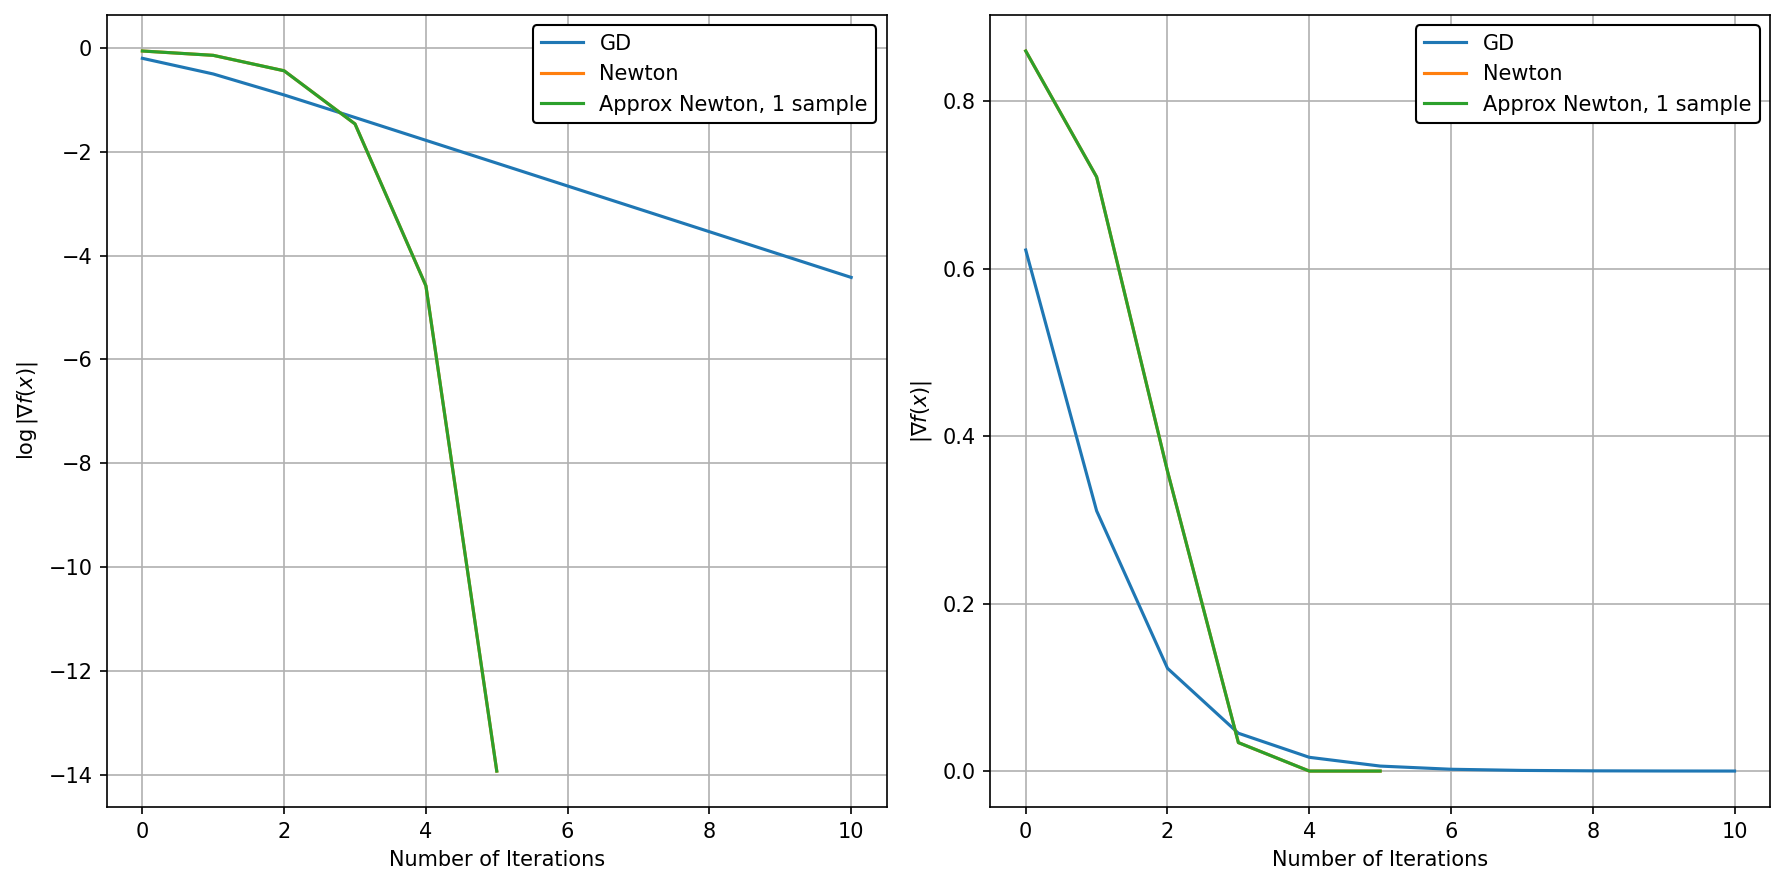

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

for points in [gd, newton, approx_1]:
    ax1.plot(range(len(points.errors)), np.log10(points.errors), label=points.label)
    ax2.plot(range(len(points.errors)), points.errors, label=points.label)

legend_box1 = ax1.legend(framealpha=1).get_frame()
legend_box1.set_facecolor("white")
legend_box1.set_edgecolor("black")
ax1.set_xlabel("Number of Iterations")
ax1.set_ylabel(r"$\log{|\nabla f(x)|}$")
ax1.grid()

legend_box2 = ax2.legend(framealpha=1).get_frame()
legend_box2.set_facecolor("white")
legend_box2.set_edgecolor("black")
ax2.set_xlabel("Number of Iterations")
ax2.set_ylabel(r"$|\nabla f(x)|$")
ax2.grid()

plt.tight_layout()
plt.show()

In [6]:
print(f"GD x_0 = 1.3: \n weight: {gd.w}; Error: {gd.errors[-1]} \n")
print(f"Newton x_0 = 1.3: \n weight: {newton.w}; Error: {newton.errors[-1]} \n")
print(f"Approx Newton x_0 = 1.3: \n weight: {approx_1.w}; Error: {approx_1.errors[-1]}")

GD x_0 = 1.3: 
 weight: 3.7885905767236246e-05; Error: 3.7885905749109836e-05 

Newton x_0 = 1.3: 
 weight: 1.2045171040057576e-14; Error: 1.2045171040057576e-14
Approx Newton x_0 = 1.3: 
 weight: [[1.2045171e-14]]; Error: 1.2045171040057576e-14


In [7]:
# sanity check
expectation = np.mean(uniform_direction.rvs(dim=1, size=100)**2, axis=0)
variance = np.var(uniform_direction.rvs(dim=1, size=100)**2, axis=0)
print("Expectation:", expectation.item())
print("Variance:", variance.item())

Expectation: 1.0
Variance: 0.0


### Mushrooms)

$\nabla^2 f(x) = \frac1n \sum\limits^{n}_{i=1}\frac{y^2_i\cdot x_ix^{\top}_i}{\left(1 + \exp{y_i\cdot(w^\top x_i)}\right)^2}\exp{\left(y_i\cdot(w^\top x_i)\right)} $

In [8]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [9]:
dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape
y = y*2 - 3
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(8124, 112) (8124,)


In [10]:
hessian = np.zeros((d, d))

for a, b in zip(X_train[:], y_train):
    hessian = hessian + 1/n  * np.outer(a, a)

hessian = hessian / 4
L = np.linalg.norm(hessian, 2)
L

2.069858337307555

In [11]:
args = {}
args['X_train'] = X_train
args['X_test']  = X_test
args['y_train'] = y_train
args['y_test']  = y_test
args['L'] = L
args['lambda'] = L / 100
args['test'] = True
args['m'] = 3
def function_log(w, args):
    sum = 0
    X = args['X_train']
    Y = args['y_train']
    n = args['X_train'].shape[0]

    for i in range(len(Y)):     
        sum = sum + 1/n * np.log(1 + np.exp(-Y[i] * X[i] @ w))  
    return sum + 0.5*args['lambda'] * w @ w

def grad_function_log(w, args):
    X = args['X_train']
    Y = args['y_train']
    sum = np.zeros(w.shape)
    n = X.shape[0]

    for i in range(len(Y)):
        sum = sum  - 1/n * Y[i] * X[i] /(1 + np.exp(-Y[i] * w @ X[i])) * np.exp(-Y[i] * w @ X[i])
    return sum + args['lambda'] * w

def hessian_function_log(w, args):
    X = args['X_train']
    Y = args['y_train']
    n = X.shape[0]
    sum = np.zeros((X.shape[1], X.shape[1]))

    for i in range(1, len(Y)):
        sum = sum + 1/n * np.outer(X[i], X[i]) * np.exp(Y[i] * w @ X[i])/((1+np.exp(Y[i] * w @ X[i])) ** 2)
    return sum + args['lambda'] * np.eye(X.shape[1])

def sample_uniform_direction(dim):
    vec = np.random.normal(0, 1, dim)
    return vec / np.linalg.norm(vec)

def approx_hessian_function_log(w, args, num_samples):
    X = args['X_train']
    Y = args['y_train']
    n = X.shape[0]
    hessian = np.zeros((X.shape[1], X.shape[1]))
    for i in range(1, len(Y)):
        hessian += 1/n * np.outer(X[i], X[i]) * np.exp(Y[i] * w @ X[i])/((1+np.exp(Y[i] * w @ X[i])) ** 2)

    approx_hessian = np.zeros_like(hessian)
    # samples = uniform_direction.rvs(dim=hessian.shape[1], size=num_samples, random_state=np.random.default_rng())
    # for u in samples:
    for _ in range(num_samples):
        u = sample_uniform_direction(hessian.shape[1])
        approx_hessian += hessian.shape[0] * hessian @ np.outer(u, u)
    approx_hessian /= num_samples
    # print('hessian', hessian + args['lambda'] * np.eye(X.shape[1]))
    # print('approx', approx_hessian + args['lambda'] * np.eye(X.shape[1]))
    return approx_hessian + args['lambda'] * np.eye(X.shape[1])

def learning_rate_log(x, args):
    return 1/args['L']

In [12]:
hessian_function_log(np.zeros(X_train.shape[1]), args=args)

array([[2.08139857e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.45468677e-02, 0.00000000e+00, ...,
        3.84674565e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.17982781e-01, ...,
        1.43483613e-02, 5.15463918e-03, 1.92337283e-03],
       ...,
       [0.00000000e+00, 3.84674565e-05, 1.43483613e-02, ...,
        5.48961522e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.15463918e-03, ...,
        0.00000000e+00, 3.18926132e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.92337283e-03, ...,
        0.00000000e+00, 0.00000000e+00, 2.66610391e-02]])

In [13]:
approx_hessian_function_log(np.zeros(X_train.shape[1]), args=args, num_samples=10000)

array([[ 2.08135294e-02,  9.46203706e-07,  3.49811302e-06, ...,
        -7.63128492e-06,  3.33983582e-06,  3.63361465e-07],
       [-5.20553819e-05,  3.46448807e-02, -5.16325597e-04, ...,
        -6.75387171e-04, -1.31588181e-04,  1.47990965e-04],
       [ 2.05857315e-03,  3.72811192e-03,  1.14133771e-01, ...,
         6.75303733e-03,  3.04410615e-03,  2.83428699e-03],
       ...,
       [ 8.43126062e-04,  1.80312169e-03,  1.28950523e-02, ...,
         5.16512513e-02, -2.97890664e-04,  2.30021507e-04],
       [ 3.54154189e-04,  3.45719692e-04,  4.63484482e-03, ...,
        -1.06424920e-03,  3.16380860e-02,  9.28745763e-05],
       [-1.00145474e-04, -1.86952658e-04,  1.68958330e-03, ...,
        -6.26398773e-04,  1.37285809e-04,  2.71690060e-02]])

In [14]:
np.linalg.norm(hessian_function_log(np.zeros(X_train.shape[1]), args=args) - approx_hessian_function_log(np.zeros(X_train.shape[1]), args=args, num_samples=10000), ord='fro')

0.26033462053551976

In [15]:
gd_mushrooms = Optimizer(func=function_log, grad_func=grad_function_log, hessian_func=hessian_function_log, w0=np.zeros(X_train.shape[1]), learning_rate=learning_rate_log, iter=50, args=args, name='gd', label='GD')
gd_mushrooms.fit()

newton_mushrooms = Optimizer(func=function_log, grad_func=grad_function_log, hessian_func=hessian_function_log, w0=np.zeros(X_train.shape[1]), learning_rate=lambda x, args: 1, iter=50, args=args, name='newton', label='Newton')
newton_mushrooms.fit()

approx_mushrooms_1 = Optimizer(func=function_log, grad_func=grad_function_log, hessian_func=approx_hessian_function_log, w0=np.zeros(X_train.shape[1]), learning_rate=lambda x, args: 1, iter=50, args=args, name='approx_newton_mushrooms', label='Approx Newton, 1')
approx_mushrooms_1.fit(num_samples=1)

approx_mushrooms_10 = Optimizer(func=function_log, grad_func=grad_function_log, hessian_func=approx_hessian_function_log, w0=np.zeros(X_train.shape[1]), learning_rate=lambda x, args: 1, iter=50, args=args, name='approx_newton_mushrooms', label='Approx Newton, 10')
approx_mushrooms_10.fit(num_samples=10)

approx_mushrooms_100 = Optimizer(func=function_log, grad_func=grad_function_log, hessian_func=approx_hessian_function_log, w0=np.zeros(X_train.shape[1]), learning_rate=lambda x, args: 1, iter=50, args=args, name='approx_newton_mushrooms', label='Approx Newton, 100')
approx_mushrooms_100.fit(num_samples=100)

approx_mushrooms_1000 = Optimizer(func=function_log, grad_func=grad_function_log, hessian_func=approx_hessian_function_log, w0=np.zeros(X_train.shape[1]), learning_rate=lambda x, args: 1, iter=50, args=args, name='approx_newton_mushrooms', label='Approx Newton, 1000')
approx_mushrooms_1000.fit(num_samples=1000)

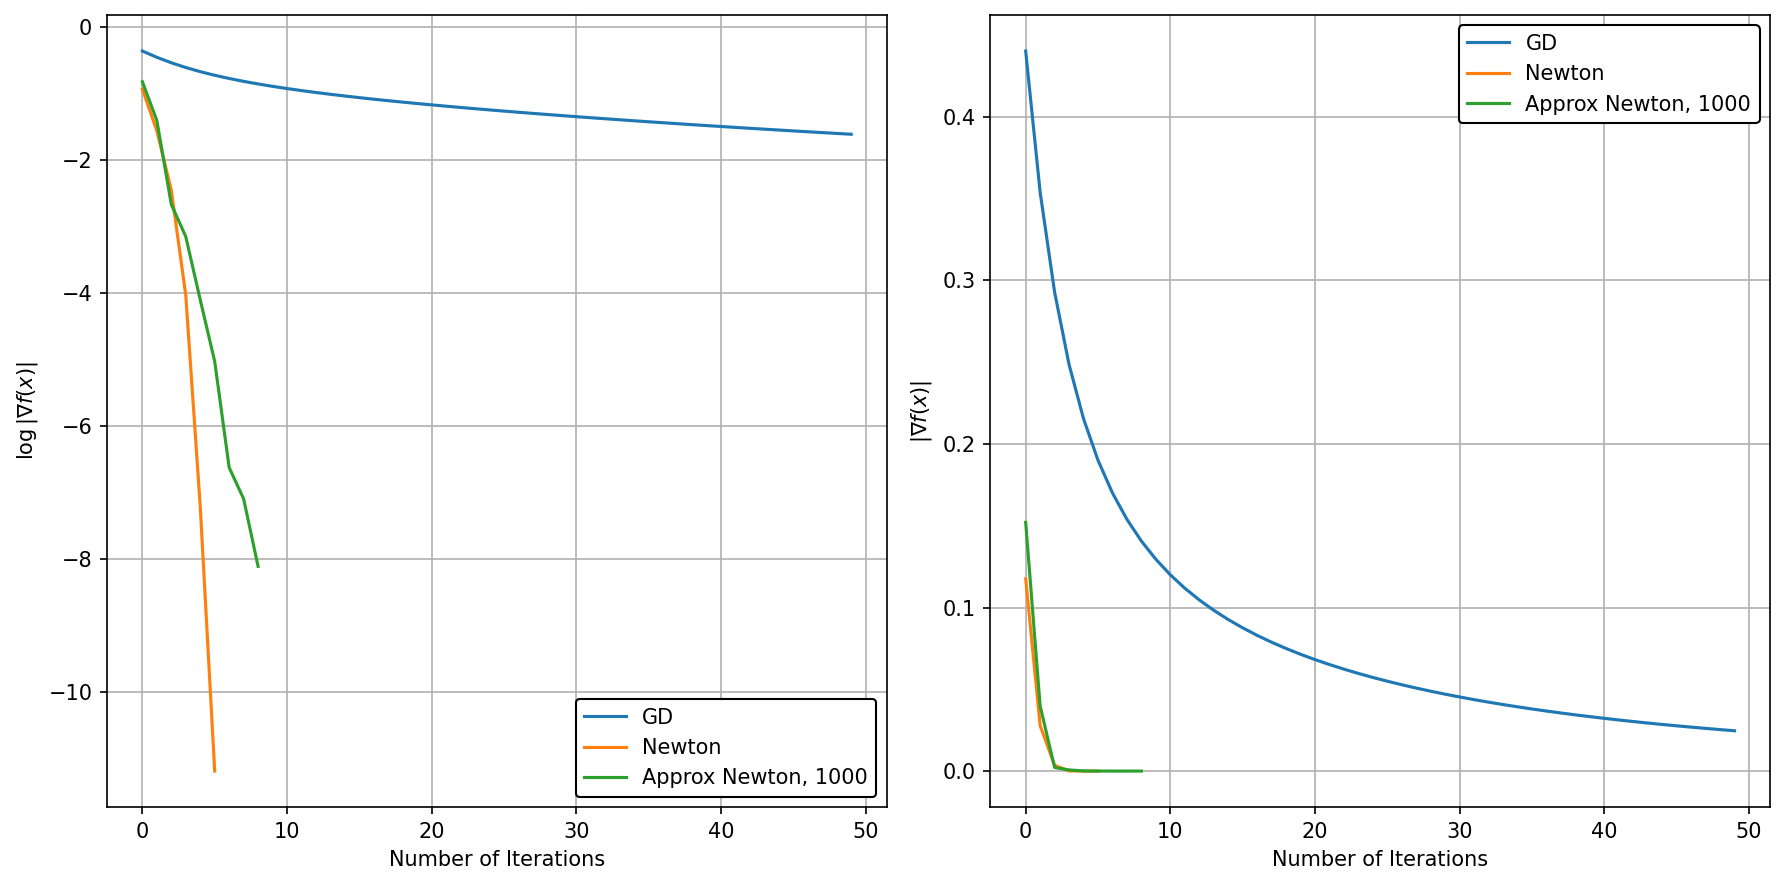

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

for points in [gd_mushrooms, newton_mushrooms, approx_mushrooms_1000]:
    ax1.plot(range(len(points.errors)), np.log10(points.errors), label=points.label)
    ax2.plot(range(len(points.errors)), points.errors, label=points.label)

legend_box1 = ax1.legend(framealpha=1).get_frame()
legend_box1.set_facecolor("white")
legend_box1.set_edgecolor("black")
ax1.set_xlabel("Number of Iterations")
ax1.set_ylabel(r"$\log{|\nabla f(x)|}$")
ax1.grid()

legend_box2 = ax2.legend(framealpha=1).get_frame()
legend_box2.set_facecolor("white")
legend_box2.set_edgecolor("black")
ax2.set_xlabel("Number of Iterations")
ax2.set_ylabel(r"$|\nabla f(x)|$")
ax2.grid()

plt.tight_layout()
plt.show()

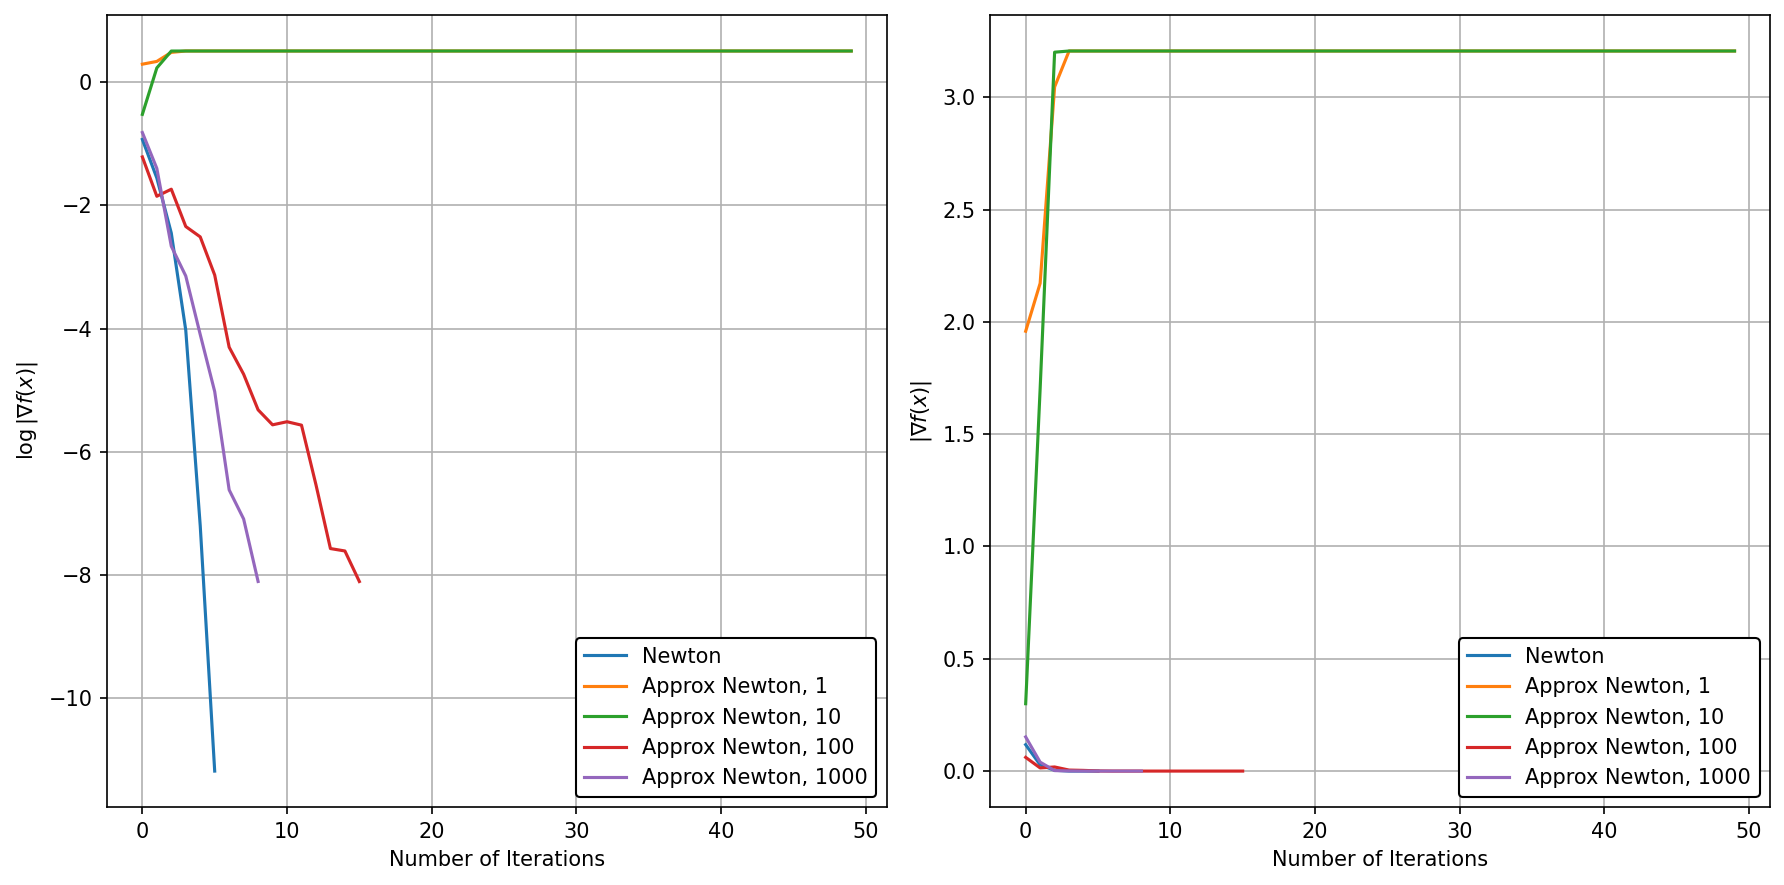

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

for points in [
               newton_mushrooms, 
               approx_mushrooms_1, 
               approx_mushrooms_10,
               approx_mushrooms_100,
               approx_mushrooms_1000
               ]:
    ax1.plot(range(len(points.errors)), np.log10(points.errors), label=points.label)
    ax2.plot(range(len(points.errors)), points.errors, label=points.label)

legend_box1 = ax1.legend(framealpha=1).get_frame()
legend_box1.set_facecolor("white")
legend_box1.set_edgecolor("black")
ax1.set_xlabel("Number of Iterations")
ax1.set_ylabel(r"$\log{|\nabla f(x)|}$")
ax1.grid()

legend_box2 = ax2.legend(framealpha=1).get_frame()
legend_box2.set_facecolor("white")
legend_box2.set_edgecolor("black")
ax2.set_xlabel("Number of Iterations")
ax2.set_ylabel(r"$|\nabla f(x)|$")
ax2.grid()

plt.tight_layout()
plt.show()

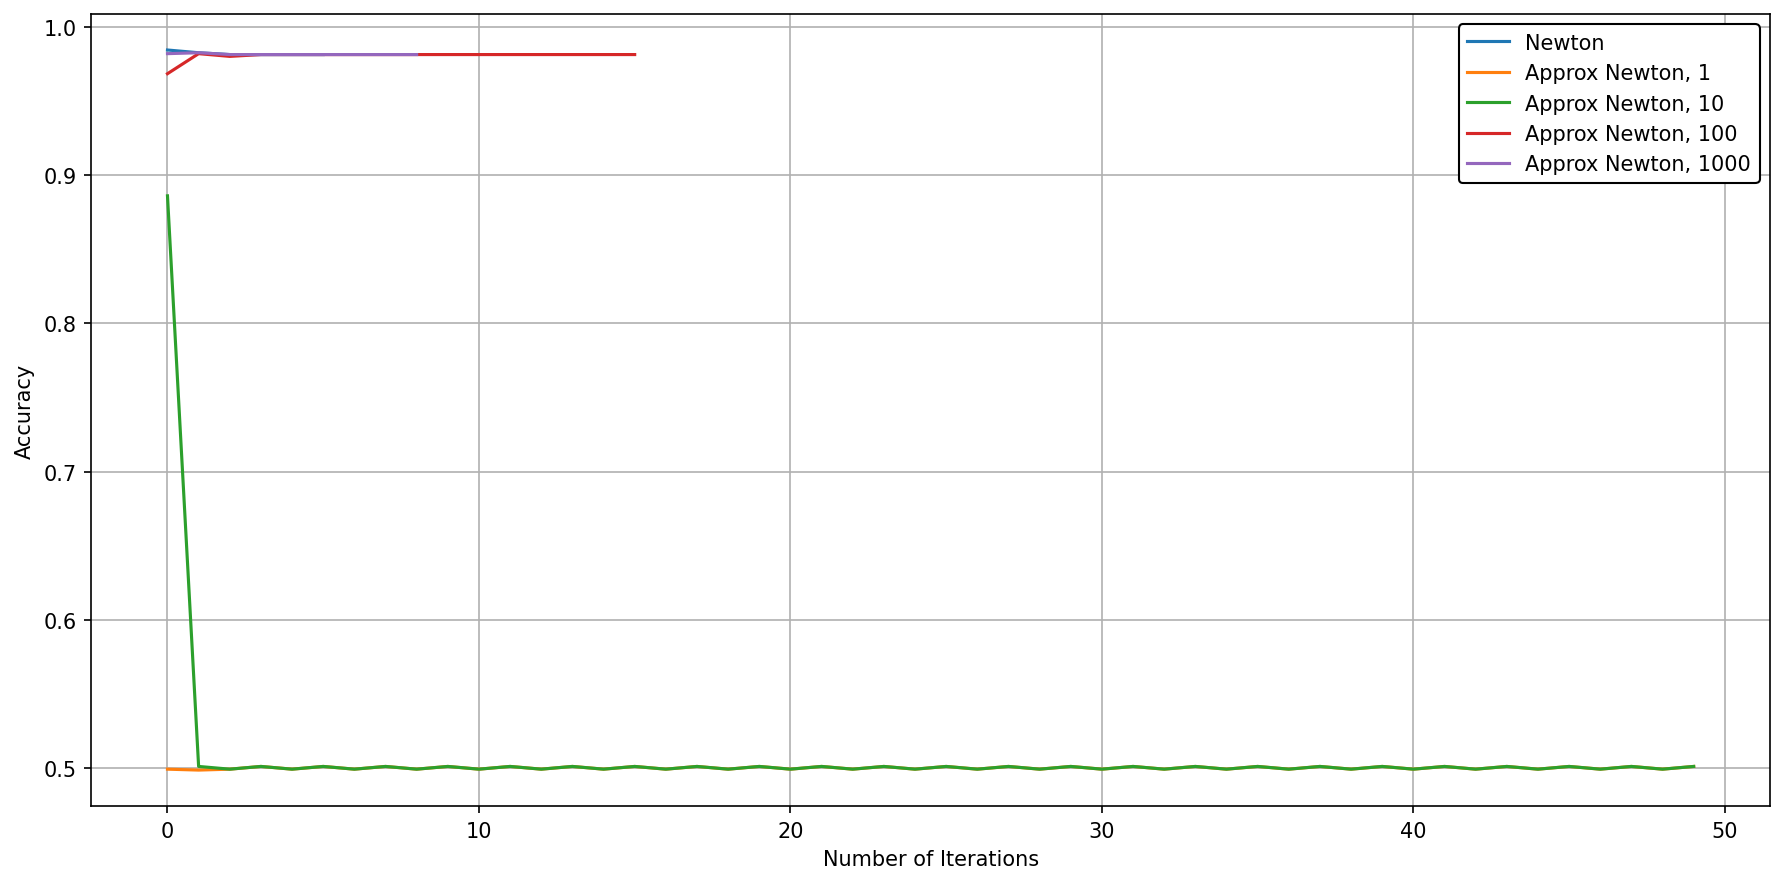

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)

for points in [
               newton_mushrooms, 
               approx_mushrooms_1, 
               approx_mushrooms_10,
               approx_mushrooms_100,
               approx_mushrooms_1000
               ]:
    ax.plot(range(len(points.accuracy)), points.accuracy, label=points.label)

legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Accuracy")
ax.grid()

plt.tight_layout()
plt.show()

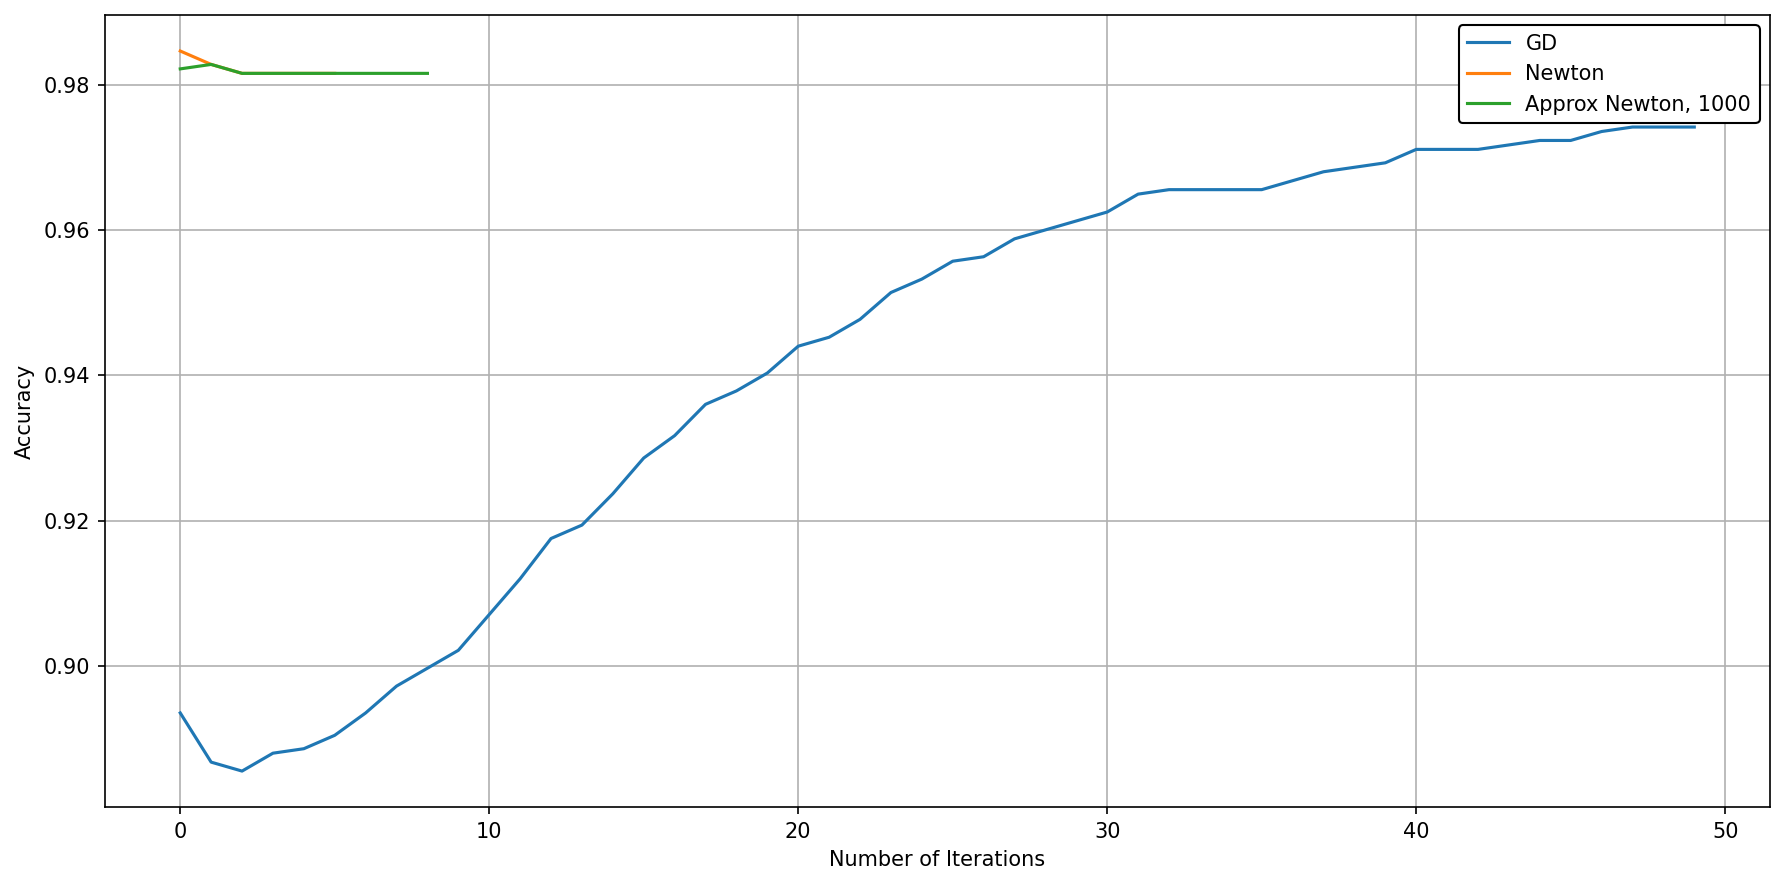

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)

for points in [
               gd_mushrooms,
               newton_mushrooms, 
               approx_mushrooms_1000,
               ]:
    ax.plot(range(len(points.accuracy)), points.accuracy, label=points.label)

legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Accuracy")
ax.grid()

plt.tight_layout()
plt.show()